# NTS Data




In [1]:
import random

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from pathlib import Path

from caveat.evaluate.describe import features
from caveat.evaluate.describe.times import (
    joint_time_distributions_plot,
    times_distributions_plot,
)
from caveat.evaluate.describe.transitions import sequence_prob_plot
from caveat.evaluate.distance import mape, emd
from caveat.evaluate.features import participation, times

In [9]:
attributes = pd.read_csv(
    "C:/Users/fred/Projects/caveat/tmp/nts_home_attributes.csv"
)


schedules = pd.read_csv(
    "C:/Users/fred/Projects/caveat/tmp/nts_home_schedules.csv"
)
synth_path = Path("C:/Users/fred/Projects/caveat/experiments/experiments4")
cvae = pd.read_csv(synth_path / "CVAESeqLSTM_XXXL/version_0/synthetic.csv")
vae = pd.read_csv(synth_path / "VAESeqLSTM_XXXL/version_0/synthetic.csv")
rnn = pd.read_csv(synth_path / "DiscLSTM_L/version_0/synthetic.csv")

KLD1 = pd.read_csv(
    synth_path / "../experiments5/CVAESeqLSTM_XXXL_kld1/version_0/synthetic.csv"
)
KLD100 = pd.read_csv(
    synth_path
    / "../experiments5/CVAESeqLSTM_XXXL_kld100/version_0/synthetic.csv"
)
KLD10000 = pd.read_csv(
    synth_path
    / "../experiments5/CVAESeqLSTM_XXXL_kld10000/version_0/synthetic.csv"
)
L1 = pd.read_csv(
    synth_path / "../experiments6/CVAESeqLSTM_XXXL_L1/version_0/synthetic.csv"
)
L3 = pd.read_csv(
    synth_path / "../experiments6/CVAESeqLSTM_XXXL_L3/version_0/synthetic.csv"
)
L5 = pd.read_csv(
    synth_path / "../experiments6/CVAESeqLSTM_XXXL_L5/version_0/synthetic.csv"
)


def age_group(age):
    if age < 17:
        return "child"

    elif age < 30:
        return "young adult"

    elif age < 65:
        return "adult"

    else:
        return "senior"


def fix_ethnicity(x):
    if x == "unknown":
        return "white"

    return x


def fix_car_access(x):
    if x == "unknown":
        return "yes"

    return x


def fix_children(x):
    if x > 2:
        return "3+"

    return str(x)


income_groups = {1: "lowest", 2: "low", 3: "medium", 4: "high", 5: "highest"}


work_groups = {
    "FT": "FT",
    "PT": "PT",
    "retired": "retired",
    "unknown": "other",
    "other": "other",
    "student": "other",
    "unemployed": "other",
}


attributes["age_group"] = attributes["age"].apply(age_group)
attributes["income_group"] = attributes["income"].apply(
    lambda x: income_groups[x]
)
attributes["ethnicity"] = attributes["ethnicity"].apply(fix_ethnicity)
attributes["work_status"] = attributes["work_status"].map(work_groups)
attributes["car_access"] = attributes["car_access"].apply(fix_car_access)
attributes["hh_children"] = attributes["hh_children"].apply(fix_children)


In [10]:
attributes.hh_children.value_counts()

hh_children
0     24215
2      7344
1      6150
3+     2141
Name: count, dtype: int64

In [11]:
def filter_on(attributes, schedules, on, minimum=1000):
    values = attributes[on].value_counts()
    selected = {}
    for value in values.index:
        pids = attributes[attributes[on] == value]["pid"]
        if len(pids) < minimum:
            selected[value] = pd.DataFrame()
        else:
            selected[value] = schedules[schedules["pid"].isin(pids)]
    return selected


def build_table(schedules, filters, op):
    participation_rates = {"all": op(schedules)}
    for filter in filters:
        for key, value in filter.items():
            participation_rates[key] = op(value)

    return pd.DataFrame(participation_rates)


def split(attributes, schedules):
    splits = {}
    splits["gender"] = filter_on(attributes, schedules, "gender")
    splits["age"] = filter_on(attributes, schedules, "age_group")
    splits["age"] = {
        i: splits["age"][i] for i in ["senior", "adult", "young adult", "child"]
    }
    splits["ethnicity"] = filter_on(attributes, schedules, "ethnicity")
    splits["education"] = filter_on(attributes, schedules, "education")
    splits["license"] = filter_on(attributes, schedules, "license")
    splits["car_access"] = filter_on(attributes, schedules, "car_access")
    splits["work"] = filter_on(attributes, schedules, "work_status")
    splits["area"] = filter_on(attributes, schedules, "area")
    splits["income"] = filter_on(attributes, schedules, "income_group")
    splits["income"] = {
        i: splits["income"][i]
        for i in ["highest", "high", "medium", "low", "lowest"]
    }
    splits["hh"] = filter_on(attributes, schedules, "hh_composition")
    splits["children"] = filter_on(attributes, schedules, "hh_children")
    splits["children"] = {
        i: splits["children"][i] for i in ["0", "1", "2", "3+"]
    }
    return splits


observed_splits = split(attributes, schedules)
cvae_splits = split(attributes, cvae)
vae_splits = split(attributes, vae)
rnn_splits = split(attributes, rnn)
KLD1_splits = split(attributes, KLD1)
KLD100_splits = split(attributes, KLD100)
KLD10000_splits = split(attributes, KLD10000)
L1_splits = split(attributes, L1)
L3_splits = split(attributes, L3)
L5_splits = split(attributes, L5)

In [ ]:
build_table(
    schedules,
    [
        gender_filtered,
        age_filtered,
        education_filtered,
        work_filtered,
        license_filtered,
        area_filtered,
        income_filtered,
    ],
    #   car_access_filtered, work_filtered, area_filtered, income_filtered],
    lambda x: features.average(times.start_times_by_act(x)),
)

In [ ]:
build_table(
    schedules,
    [
        gender_filtered,
        age_filtered,
        education_filtered,
        license_filtered,
        area_filtered,
        income_filtered,
    ],
    lambda x: features.sd(times.start_times_by_act(x)),
)

In [ ]:
fig = times_distributions_plot(schedules, work_filtered)

acts:  {'work', 'education', 'other', 'visit', 'medical', 'home', 'shop', 'escort'}
dict_keys(['obs', 'KLD1', 'KLD100', 'KLD10000'])


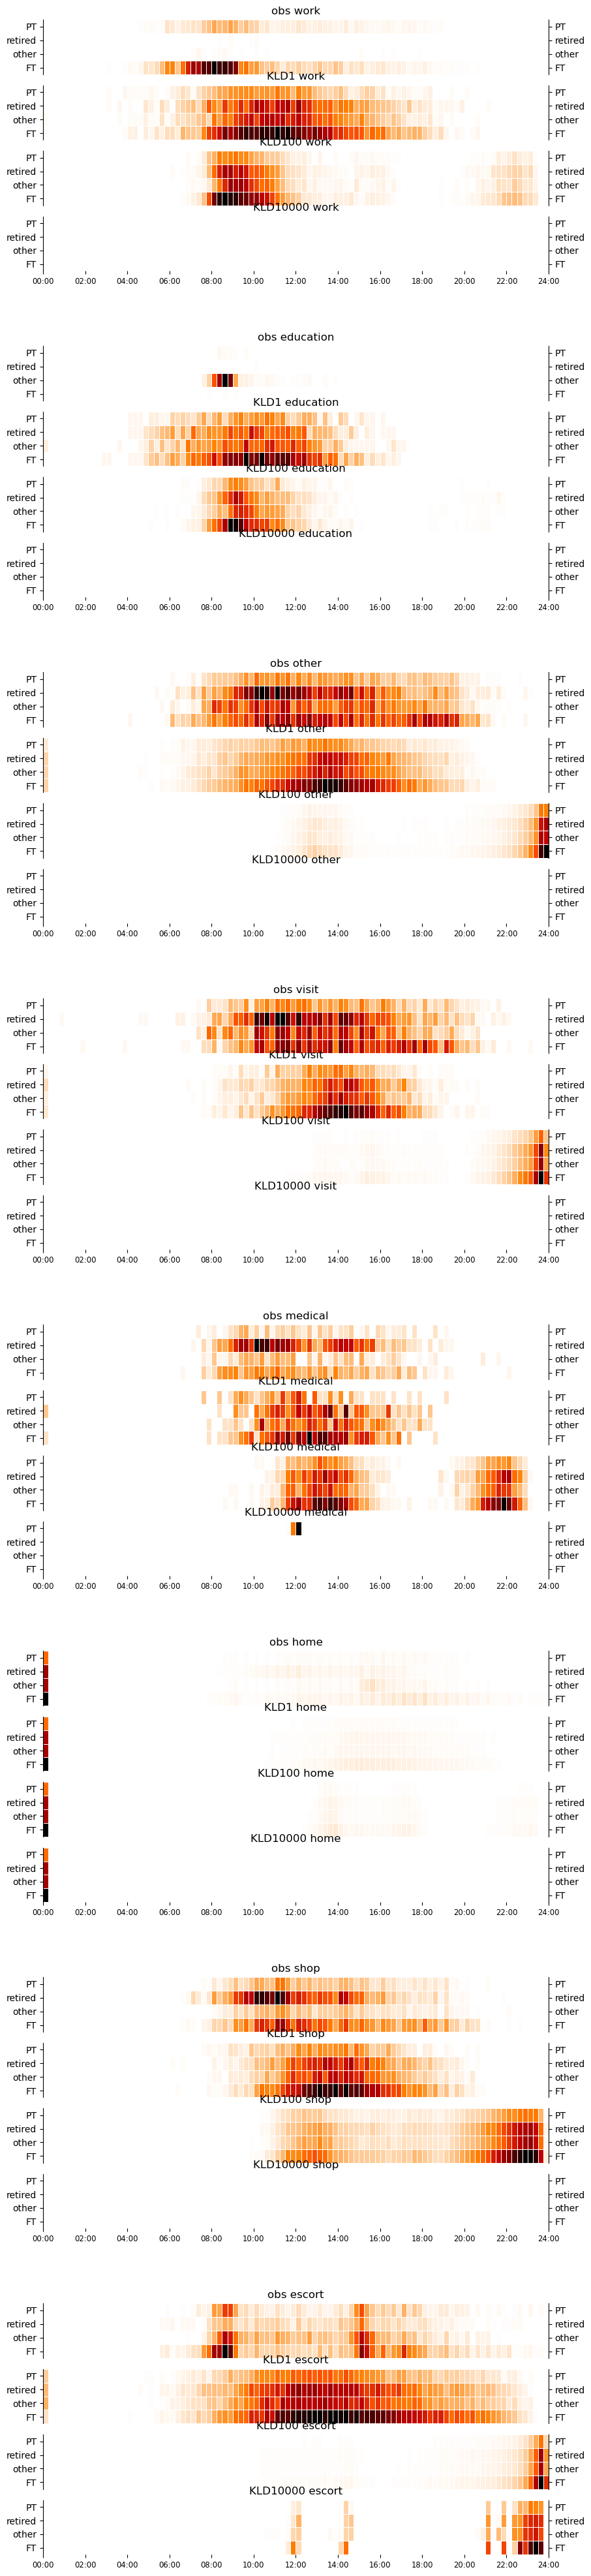

In [12]:
def plot_times(
    subs,
    column="start",
    acts=None,
    normalise=False,
    minimum=0,
    maximum=1440,
    plot_width=10,
):
    if acts is None:
        acts = set()
        for data in subs.values():
            acts.update(set(data.act))

    print("acts: ", acts)

    splits = {
        k: extract_activities(v, column, minimum, maximum)
        for k, v in subs.items()
    }
    print(splits.keys())

    return plot_bins(
        splits,
        acts,
        column,
        normalise=normalise,
        minimum=minimum,
        maximum=maximum,
        width=plot_width,
    )


def extract_activities(schedules, column, minimum, maximum):
    data = schedules.copy()
    if minimum is not None:
        data = data[data[column] >= minimum]
    if maximum is not None:
        data = data[data[column] <= maximum]
    return pd.DataFrame(
        {
            "act": data.act,
            "start": (data.start).astype(int),
            "end": (data.end).astype(int),
            "duration": (data.duration).astype(int),
        }
    )


def plot_bins(
    splits,
    acts,
    column,
    width=10,
    height_factor=1.2,
    normalise=False,
    minimum=0,
    maximum=1440,
):
    fig, axs = plt.subplots(
        len(acts),
        figsize=(width, len(acts) * (len(splits) + 1) / 4),
        sharex=False,
    )
    if not isinstance(axs, np.ndarray):
        axs = [axs]

    mmhours = int(minimum / 60)
    mxhours = int(maximum / 60)
    duration = mxhours - mmhours
    step = 2

    for ax, act in zip(axs, acts):
        keys = list(splits.keys())
        n_keys = len(keys)
        binned = time_binner(splits, act, column, minimum, maximum)
        if normalise:
            binned = binned / binned.max()
        ax.pcolormesh(
            binned.T, cmap="gist_heat_r", edgecolors="white", linewidth=0.5
        )
        ax.xaxis.set_ticks([i for i in range(0, duration * 4 + 1, 8)])
        ax.set_xticklabels(
            [f"{h:02}:00" for h in range(mmhours, mxhours + 1, step)],
            size="small",
        )
        ax.yaxis.set_ticks([i + 0.5 for i in range(n_keys)])
        ax.yaxis.set_ticklabels(keys)
        ax.grid(which="minor", color="w", linestyle="-", linewidth=2)
        ax.tick_params(right=True, labelright=True)
        for pos in ["top", "bottom"]:
            ax.spines[pos].set_visible(False)
        ax.set_title(act.title(), fontsize="medium", rotation=0)

    fig.tight_layout()
    return fig


def time_binner(splits, act, column, minimum, maximum):
    """Bin start and end times and durations, return freq table for X hour period, 15min intervals."""
    bins = list(range(minimum, maximum + 1, 15))
    # bins[-1] = 100 * 60
    start = f"{int(minimum/60):02}:00:00"
    periods = int((maximum - minimum) / 15)
    labels = pd.timedelta_range(start=start, periods=periods, freq="15min")
    binned = pd.DataFrame(
        index=pd.timedelta_range(start=start, periods=periods, freq="15min")
    )
    for key, data in splits.items():
        split = data[data.act == act]
        binned[key] = pd.cut(
            split[column], bins, labels=labels, right=False
        ).value_counts()

    return binned


def plot_times_compare(
    splits,
    column="start",
    acts=None,
    normalise=False,
    minimum=0,
    maximum=1440,
    plot_width=10,
):
    if acts is None:
        acts = set()
        for split in splits.values():
            for data in split.values():
                acts.update(set(data.act))

    print("acts: ", acts)

    processed_splits = {}
    for name, split in splits.items():
        processed_splits[name] = {
            k: extract_activities(v, column, minimum, maximum)
            for k, v in split.items()
        }
    print(splits.keys())

    return plot_bins_compare(
        splits,
        acts,
        column,
        normalise=normalise,
        minimum=minimum,
        maximum=maximum,
        width=plot_width,
    )


def plot_bins_compare(
    splits,
    acts,
    column,
    width=10,
    height_factor=1.2,
    normalise=False,
    minimum=0,
    maximum=1440,
):
    fig = plt.figure(
        # constrained_layout=True,
        figsize=(width, len(acts) * (len(splits) + 1) * len(splits) / 4)
    )

    subfigs = fig.subfigures(len(acts), 1)
    mmhours = int(minimum / 60)
    mxhours = int(maximum / 60)
    duration = mxhours - mmhours
    step = 2

    for act, subfig in zip(acts, subfigs.flat):
        # subfig.suptitle(f'Subfig {outerind}')
        axs = subfig.subplots(len(splits), 1)
        for name, split, ax in zip(splits.keys(), splits.values(), axs.flat):
            ax.set_title(f"{name} {act}")
            # ax.set_xticks([])
            # ax.set_yticks([])

            keys = list(split.keys())
            n_keys = len(keys)
            binned = time_binner(split, act, column, minimum, maximum)
            if normalise:
                binned = binned / binned.max()
            ax.pcolormesh(
                binned.T, cmap="gist_heat_r", edgecolors="white", linewidth=0.5
            )
            ax.set_xticks([])
            ax.yaxis.set_ticks([i + 0.5 for i in range(n_keys)])
            ax.yaxis.set_ticklabels(keys)
            ax.grid(which="minor", color="w", linestyle="-", linewidth=2)
            ax.tick_params(right=True, labelright=True)
            for pos in ["top", "bottom"]:
                ax.spines[pos].set_visible(False)
            # ax.set_title(act.title(), fontsize="medium", rotation=0)
        ax.xaxis.set_ticks([i for i in range(0, duration * 4 + 1, 8)])
        ax.set_xticklabels(
            [f"{h:02}:00" for h in range(mmhours, mxhours + 1, step)],
            size="small",
        )

    # fig.tight_layout()
    return fig


fig = plot_times_compare(
    splits={
        "obs": observed_splits["work"],
        "KLD1": KLD1_splits["work"],
        "KLD100": KLD100_splits["work"],
        "KLD10000": KLD10000_splits["work"],
    },
    column="start",
    normalise=False,
    minimum=0,
    maximum=1440,
    plot_width=10,
)

acts:  {'work', 'education', 'other', 'visit', 'medical', 'home', 'shop', 'escort'}
dict_keys(['obs', 'KLD1', 'KLD100', 'KLD10000'])


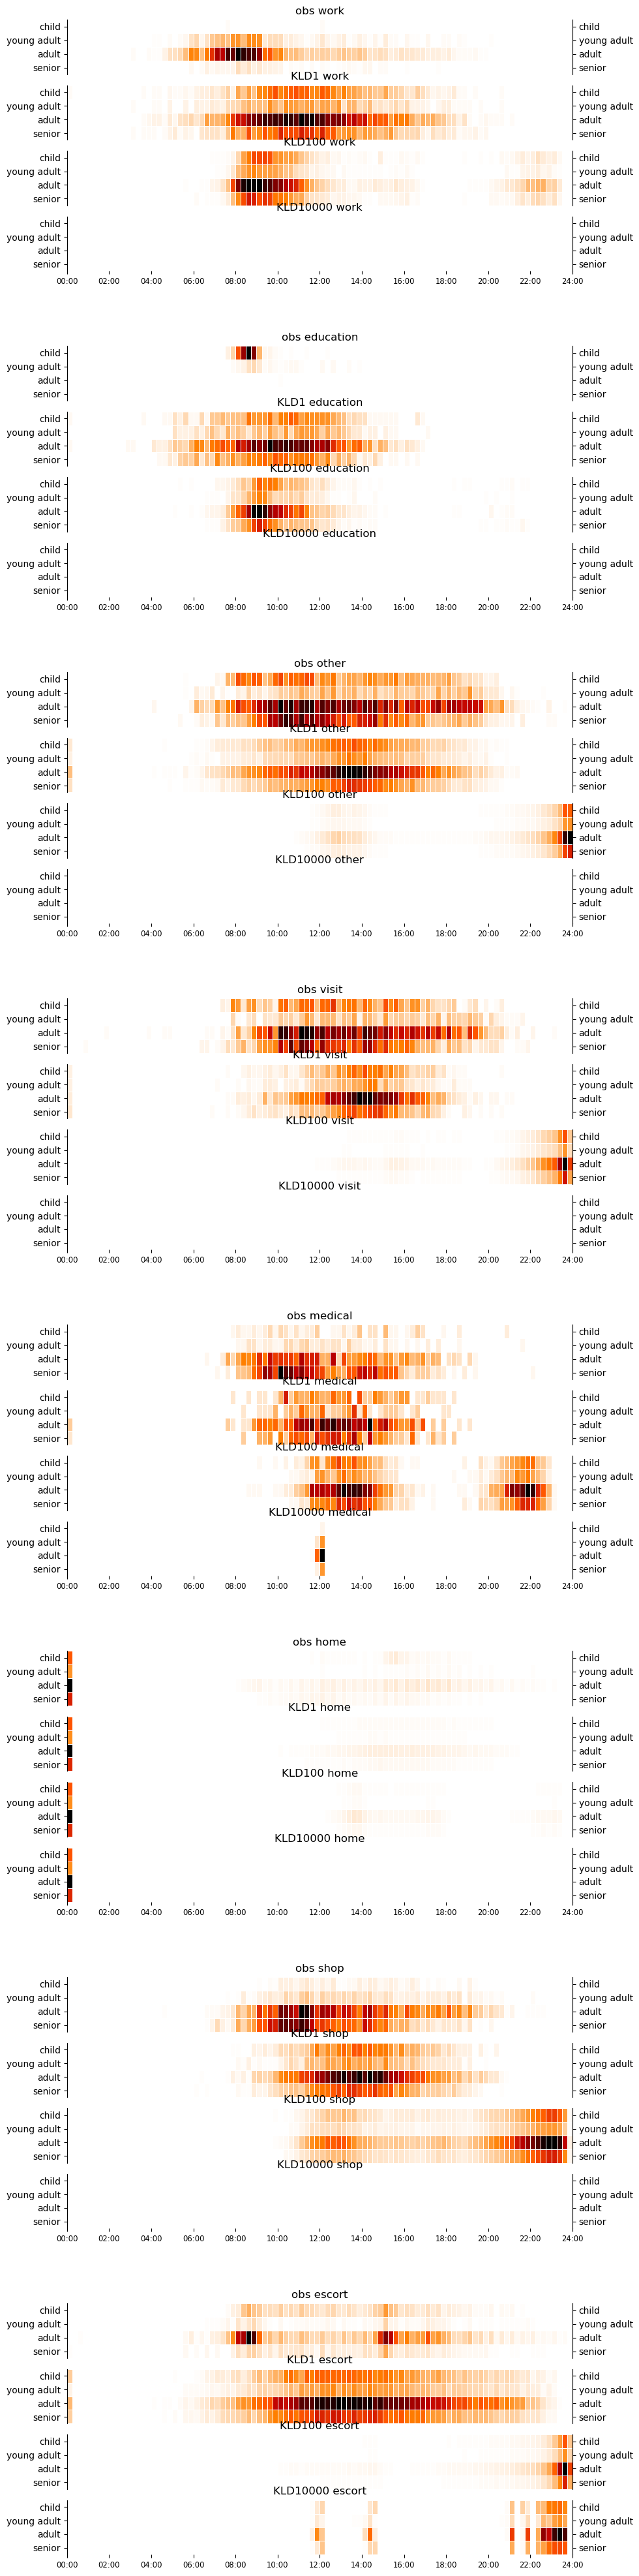

In [13]:
fig = plot_times_compare(
    splits={
        "obs": observed_splits["age"],
        "KLD1": KLD1_splits["age"],
        "KLD100": KLD100_splits["age"],
        "KLD10000": KLD10000_splits["age"],
    },
    column="start",
    normalise=False,
    minimum=0,
    maximum=1440,
    plot_width=10,
)


In [ ]:
fig = plot_times(
    observed_splits["work"],
    column="start",
    normalise=False,
    minimum=0,
    maximum=1440,
    plot_width=10,
)

In [ ]:
fig = plot_times(
    children_filtered,
    column="start",
    normalise=False,
    minimum=0,
    maximum=1440,
    plot_width=10,
)

In [ ]:
op = lambda x: features.average(participation.participation_rates_by_act(x))

build_table(
    schedules,
    [
        gender_filtered,
        age_filtered,
        education_filtered,
        license_filtered,
        area_filtered,
        income_filtered,
    ],
    op,
)

In [ ]:
fig = sequence_prob_plot(schedules, observed_splits["age"], figsize=(12, 4))

In [ ]:
fig = sequence_prob_plot(cvae, cvae_splits["work"], figsize=(12, 4))

In [ ]:
fig = sequence_prob_plot(schedules, education_filtered, figsize=(12, 4))

In [ ]:
fig = sequence_prob_plot(schedules, income_filtered, figsize=(12, 4))

In [ ]:
fig = sequence_prob_plot(schedules, area_filtered, figsize=(12, 4))

In [ ]:
fig = joint_time_distributions_plot(schedules, gender_filtered, figsize=(10, 6))

In [ ]:
fig = joint_time_distributions_plot(schedules, age_filtered, figsize=(10, 8))